# Making  GAIA DR2 star catalogs for PhoSim simulations

In [118]:
#NB: use Python 3 - AXS Spark kernel for that 
#that's the one that has mariadb...

import pandas as pd
import numpy as np
import mysql.connector as mariadb

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_columns',100)
pd.set_option('float_format', '{:f}'.format)

import matplotlib.pyplot as plt
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


from astropy.table import Table
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join

from astropy.time import Time

from astropy.coordinates import SkyCoord
from astropy import units as u


import pyspark.sql.functions as sparkfunc
from pyspark.sql import SparkSession

spark_session = (SparkSession.builder
         .config('spark.master', "local[20]")
         .config('spark.driver.memory', '20G')
         .enableHiveSupport()
         .getOrCreate())

import axs
axs_catalog = axs.AxsCatalog(spark_session)
gaia = axs_catalog.load("gaia_dr2_1am_dup")

NB: need to use `Python 3 - AXS Spark` kernel, because that's the one that has mariaDB and AXS. 

Show which cols are available for GAIA :

In [19]:
np.ravel(gaia.columns)

array(['solution_id', 'designation', 'source_id', 'random_index',
       'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error',
       'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr',
       'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr',
       'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr',
       'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al',
       'astrometric_n_obs_ac', 'astrometric_n_good_obs_al',
       'astrometric_n_bad_obs_al', 'astrometric_gof_al',
       'astrometric_chi2_al', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'astrometric_params_solved',
       'astrometric_primary_flag', 'astrometric_weight_al',
       'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error',
       'mean_varpi_factor_al', 'astrometric_matched_observations',
       'visibility_periods_used', 'astrometric_sigma5d_max',
       'frame_rotator_object

### Read in the Galfast simulation as background of stellar counts in a simulated LSST night sky 

I use the Galfast simulation of the LSST sky as the background to show the location of chosen fields according to Galactic coordinates

In [73]:
os.chdir('/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_notebooks/')

In [74]:
import healpy as hp 
def make_healpix_table(r_max=24.5):
    ''' A convenience function 
    to read in the MAF simulation data,
    and given the limiting r magnitude, 
    return stellar density per healpixel,
    and the fraction of healpixels with higher
    density , together with ra,dec coord 
    of each healpixel. We use the constraint 
    r < r_max, with  65 magnitude bins between 
    15 and 28 mag every 0.2 mag. 
    
    '''
    # the data consists of 
    # data['starDensity'],  expressed as stars / sq. deg  ,  per pixel, per magnitude
    # data['bins'], defining the magnitude ranges for each of the 65 magnitude bins 
    # data['overMaxMask'], which tells where there are more than 1e6 stars 
    data = np.load('starDensity_r_nside_64.npz')


    # Cumulative number counts, units of stars/sq deg. Array at healpix locations
    # magnitude bins 
    mag_bins = data['bins'].copy()
    # pixels where there were so many  (1e6 ) stars some were skipped
    mask = data['overMaxMask'].copy()
    # in this simulation none were skipped : 
    # np.sum(mask) = 0

    # select only bins up to r_max - then selecting the final bin will 
    # give us the source count up to depth of r_max mag 
    bright_mag_idx, = np.where(mag_bins<r_max)
    print('Selecting only the source density up \
    to the depth of ', r_max, ' mag')
    faintest_mag_idx = bright_mag_idx[-1]

    # Since the data is already cumulative, just choose the  last bin: 
    # this will have the number of stars up to the faintest magnitude 
    # bin in a given  healpixel 
    starDensity_lt_245 = data['starDensity'][:,faintest_mag_idx]
    # len(starDensity_lt_245) = len(data['starDensity]) = 49142

    # Generate the ra, dec array from healpy
    nside = hp.npix2nside(np.size(mask))
    lat,ra = hp.pix2ang(nside, np.arange(np.size(mask)))
    dec = np.pi/2-lat

    # only select those healpixels for which we have any simulation data ...
    m = starDensity_lt_245 > 0

    density = starDensity_lt_245[m]
    ra = ra[m]
    dec = dec[m]

    # For each pixel calculate how many pixels have a higher or equal density 
    N_px_greater  = np.zeros_like(density)
    for i in range(len(density)):
        N_px_greater[i]=np.sum(density>=density[i])

    # calculate the fraction of pixels that have a higher density (by area)
    frac_greater  = N_px_greater /  len(density)

    # Make an AstroPy table with healpix data...

    healpix_table = Table([density, ra,dec, N_px_greater, frac_greater], 
                          names=('source_density','ra_rad','dec_rad', 'N_px_greater', 
                                 'frac_greater'))
    return healpix_table , nside

In [75]:
healpix_table, nside = make_healpix_table()

Selecting only the source density up     to the depth of  24.5  mag


In [76]:
healpix_coords = SkyCoord(healpix_table['ra_rad'],
                          healpix_table['dec_rad'], 
                          frame='icrs', unit='rad')

### Define the GAIA fields

Define the four fields to query at four locations: high (80-90 deg); medium (30-50 deg); low (0 - 20 deg) galactic latitudes, and Baade's window (l,b)=(1.02,-3.92) [deg]
    

In [84]:
gt = Table(data=[['high','med','low','Baade'],
                            [0,0,0,1.02],
                           [85,40,10,-3.92 ]], 
                      names=['name', 'l_deg','b_deg'])

gaia_coords = SkyCoord(l=gt['l_deg'],b=gt['b_deg'], 
                       frame='galactic', unit='deg')

gt['ra_deg'] = gaia_coords.icrs.ra.deg
gt['dec_deg'] = gaia_coords.icrs.dec.deg



In [85]:
gt

name,l_deg,b_deg,ra_deg,dec_deg
str5,float64,float64,float64,float64
high,0.0,85.0,197.46441300863182,24.33554243027582
med,0.0,40.0,233.01733592061052,-4.447088188407342
low,0.0,10.0,257.11044958320826,-23.40973217864059
Baade,1.02,-3.92,270.88380338652223,-30.035274475954893


Also, do the region in/around Magellanic clouds:

In [86]:
lmc_coord = SkyCoord.from_name("LMC")
smc_coord = SkyCoord.from_name("SMC")
# based on http://sky-map.org/ 
around_smc = SkyCoord("01h28m47s-75deg22min", frame='icrs',)
around_lmc = SkyCoord("04h30m28s-68deg44min17sec", frame='icrs')

# store these in an astroPy table 
names = ['inLMC', 'inSMC', 'aroundLMC', 'aroundSMC']
l_deg = []
b_deg = []
ra_deg = []
dec_deg = []
for  coord in [lmc_coord, smc_coord, around_smc, around_lmc]:
    l_deg.append(coord.galactic.l.deg)
    b_deg.append(coord.galactic.b.deg)
    ra_deg.append(coord.icrs.ra.deg)
    dec_deg.append(coord.icrs.dec.deg)
    
magellanic = Table(data=[names, l_deg, b_deg, ra_deg, dec_deg],
                   names = ['name', 'l_deg', 'b_deg', 'ra_deg', 'dec_deg'])

# combine with the list of GAIA  fields 
gt_magellan = vstack([gt,magellanic])

# save  the merged tables 
gt_magellan.write('GAIA_DR2_Galactic_fields.txt', format='ascii', overwrite='True')

In [87]:
gt_magellan


name,l_deg,b_deg,ra_deg,dec_deg
str9,float64,float64,float64,float64
high,0.0,85.0,197.46441300863182,24.33554243027582
med,0.0,40.0,233.01733592061052,-4.447088188407342
low,0.0,10.0,257.11044958320826,-23.40973217864059
Baade,1.02,-3.92,270.88380338652223,-30.035274475954893
inLMC,280.46522149663633,-32.88840179258582,80.89416667,-69.75611111
inSMC,302.8083890757778,-44.32768789476316,13.15833333,-72.80027778
aroundLMC,299.7933935547725,-41.53321041969505,22.195833333333333,-75.36666666666666
aroundSMC,280.9577755577122,-37.67486717046375,67.61666666666666,-68.73805555555556


### Show with SkyView that the LMC position is correct

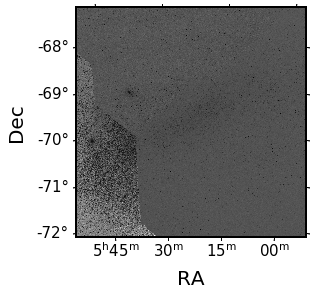

In [65]:
# from https://astroquery.readthedocs.io/en/latest/gallery.html
from astropy import coordinates, units as u, wcs
from astroquery.skyview import SkyView
from astroquery.vizier import Vizier
import pylab as pl

center = lmc_coord

# Grab an image from SkyView 
imglist = SkyView.get_images(position=center, survey='DSS',#['SDSSg','Fermi 5', 'HRI', 'DSS'],
                            radius=5*u.deg)

# the returned value is a list of images, but there is only one
img = imglist[0]

# 'img' is now a fits.HDUList object; the 0th entry is the image
mywcs = wcs.WCS(img[0].header)

fig = pl.figure(1)
fig.clf() # just in case one was open before
# use astropy's wcsaxes tool to create an RA/Dec image
ax = fig.add_axes([0.15, 0.1, 0.8, 0.8], projection=mywcs)
ax.set_xlabel("RA")
ax.set_ylabel("Dec")

ax.imshow(np.log10(img[0].data), cmap='gray_r', interpolation='none', origin='lower',
          )


### Illustrate the GAIA fields on the GALFAST map of Milky Way

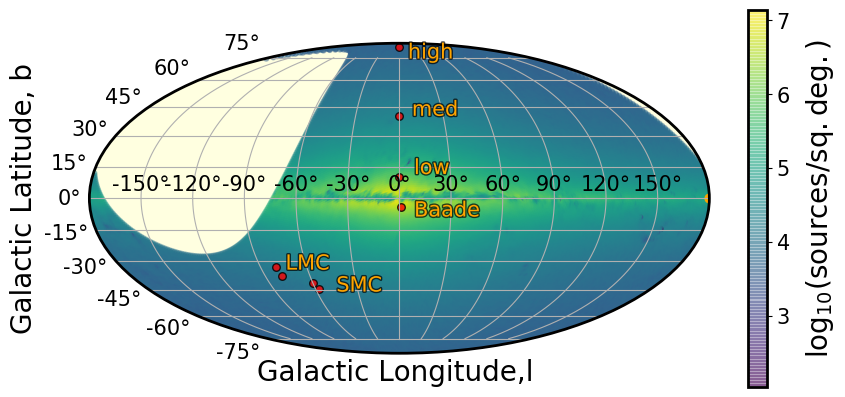

In [119]:
# Define the tick formatter to have degrees ....
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches
import matplotlib.patheffects as PathEffects
import matplotlib
rcParams = matplotlib.rcParams
#from astroML.plotting import setup_text_plots
#setup_text_plots( usetex=True)

def degrees( x, pos=None):
    """
    Used to format the theta tick labels.  Converts the native
    unit of radians into degrees and adds a degree symbol.
    """
    degrees = (x / np.pi) * 180.0
    degrees = np.round(degrees)
    if rcParams['text.usetex'] and not rcParams['text.latex.unicode']:
        return r"$%0.0f^\circ$" % degrees
    else:
        return "%0.0f\u00b0" % degrees
    
# plotting  in mollweide projection ...  
# express the MAF healpixel coords in galactic 
# coords,  in degrees 
healpix_longitude = healpix_coords.galactic.l.deg
healpix_latitude  = healpix_coords.galactic.b.deg

# shift the scale : healpix is 0, 360, and we want to go -180,180 
ind = healpix_longitude > 180
healpix_longitude[ind] -=360    # scale conversion to [-180, 180]
healpix_longitude = - healpix_longitude   # reverse the scale: East to the left

# color by the log of counts per sq deg 
z =  np.log10(healpix_table['source_density'].data)

# Plot in Mollweide projection the MAF densities 
# in Galactic coordinates 
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(111, projection='mollweide', facecolor ='LightYellow')

# convert degrees to radians
imge = ax.scatter(np.radians(healpix_longitude),
                  np.radians(healpix_latitude),  
                  alpha=0.4, s=14, c=z,
                  zorder=-5) # make sure that the background is underneath everything else with zorder  

# plot the four GAIA fields 
gt = Table.read('GAIA_DR2_Galactic_fields.txt', format='ascii')
gaia_coords = SkyCoord(l=gt['l_deg'],b=gt['b_deg'], 
                       frame='galactic', unit='deg')
gaia_longitude = gaia_coords.galactic.l.rad
gaia_latitude = gaia_coords.galactic.b.rad

# switch the range of coords from (0,2pi) to (-pi,pi) for longitude
ind = gaia_longitude>np.pi
gaia_longitude[ind] -= 2*np.pi
#gaia_longituge =- gaia_longitude

# this only plots the gaia coords as same-size markers. 
ax.scatter(gaia_longitude, gaia_latitude, alpha=0.8, s=30,c='red',
          edgecolors='black')

ax.scatter(np.pi, 0, s=40,c='orange')
# chosen by hand for no overlap with other plot elements
# these are in radians 
xtext = {'high':0.2, 'med':0.15, 'low':0.15, 'Baade':0.15, 'LMC':-1.3, 'SMC':-0.8}
ytext={'high':1.3, 'med':0.7, 'low':0.2, 'Baade':-0.15, 'LMC':-0.6, 'SMC':-0.8}

# annotate each field 
i = 0 
for key in xtext.keys():
    xc = gaia_longitude[i]
    yc = gaia_latitude[i]
    name = key
    txt = ax.annotate(name, xy=(xc,yc),xytext=(xtext[name],ytext[name]),
               color='orange')
    # from
    # https://osxastrotricks.wordpress.com/2014/12/02/add-border-around-text-with-matplotlib/
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black',alpha=0.7)])
    i += 1 
    #plt.draw()

# Also, plot the SMC,LMC fields 
#ax.scatter(lmc_coord.galactic.l.rad, lmc_coord.galactic.b.rad)


# set the tick labels with degree formatting 
origin = 0
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+origin,360)
ax.set_xticklabels(tick_labels)  
ax.xaxis.set_major_formatter(FuncFormatter(degrees))
ax.set_xlabel('Galactic Longitude,l ')
ax.set_ylabel('Galactic Latitude, b')
ax.grid(True)
cbar = plt.colorbar(imge)
cbar.set_label(r'$\log_{10}{(\mathrm{sources / sq.deg.})}$', labelpad=10)
#plt.savefig('MAF_DECAPS.png',  bbox_inches='tight')

### Do the Spark query:

Each query is a square centered on (ra,dec), with size +/- a, where `a` is the half-width of the FOV. I find that around 0.387 degrees is needed for ComCam. The actual ComCam half-width of FOV (0.352 degrees) is sufficient for high latitudes, but results in a strip of stars along the upper and lower edge missing for lower galactic latitudes.  

In [121]:
gt[4:]

name,l_deg,b_deg,ra_deg,dec_deg
str9,float64,float64,float64,float64
inLMC,280.46522149663633,-32.88840179258582,80.89416667,-69.75611111
inSMC,302.8083890757778,-44.32768789476316,13.15833333,-72.80027778
aroundLMC,299.7933935547725,-41.53321041969505,22.195833333333333,-75.36666666666666
aroundSMC,280.9577755577122,-37.67486717046375,67.61666666666666,-68.73805555555556


In [123]:
%%time 

gt = Table.read('GAIA_DR2_Galactic_fields.txt', format='ascii')
a = 0.4 # just to be sure ... 
#a = 0.387 # half-width of comcam FOV in deg  - needed to increase from .352,
# because while this was enough in ra, it left a stripe about 10% of the CCD size
# iterate over centers of each square 

# note:  _gaia_DR2_comcam.txt   used a = 0.352, but it turned out insufficient on the edges,
# so I expanded that to a = 0.387, storing as _gaia_DR2_comcam_wide.txt

for ra, dec, name in zip(gt['ra_deg'], gt['dec_deg'],gt['name'] ):
    ra_min = ra - a
    ra_max = ra + a
    dec_min = dec - a 
    dec_max = dec + a 
    print('Querying  %s:  %.3f<ra<%.3f   , %.3f<dec<%.3f'%\
          (name, ra_min,ra_max,dec_min,dec_max))
    res_pd = gaia.region(ra1=ra_min, ra2=ra_max, 
                         dec1=dec_min, dec2=dec_max).select("ra", 
                        "dec","phot_g_mean_mag","phot_variable_flag",
                        "designation",  "phot_g_n_obs","dup").toPandas()
    res = Table.from_pandas(res_pd)
    res.write(name+'_gaia_DR2_comcam_wide.txt',format='ascii', overwrite=True)

Querying  inLMC:  80.494<ra<81.294   , -70.156<dec<-69.356
Querying  inSMC:  12.758<ra<13.558   , -73.200<dec<-72.400
Querying  aroundLMC:  21.796<ra<22.596   , -75.767<dec<-74.967
Querying  aroundSMC:  67.217<ra<68.017   , -69.138<dec<-68.338
CPU times: user 15.6 s, sys: 1.89 s, total: 17.5 s
Wall time: 54.4 s


Count the stars in each catalog:

In [124]:
gt = Table.read('GAIA_DR2_Galactic_fields.txt', format='ascii')

#Count the stars 
stars = {}
for i in range(len(gt)):
    name = gt['name'][i]
    t = Table.read(name+'_gaia_DR2_comcam_wide.txt',format='ascii')
    stars[name] = t 
    print('For %s we have %d stars'%(name,len(t)))

For high we have 1759 stars
For med we have 5805 stars
For low we have 222070 stars
For Baade we have 540262 stars
For inLMC we have 266258 stars
For inSMC we have 187989 stars
For aroundLMC we have 2784 stars
For aroundSMC we have 9295 stars


Quickly illustrate the stellar density that we would expect: 

0.0 0.7734180502208403
0.0 0.772923556367278
0.0 0.7739927186392777
0.0 0.7737698809579623
0.0 0.7739887381409858
0.0 0.7739904726150684
0.0 0.7739931986863553
0.0 0.7739969407578613


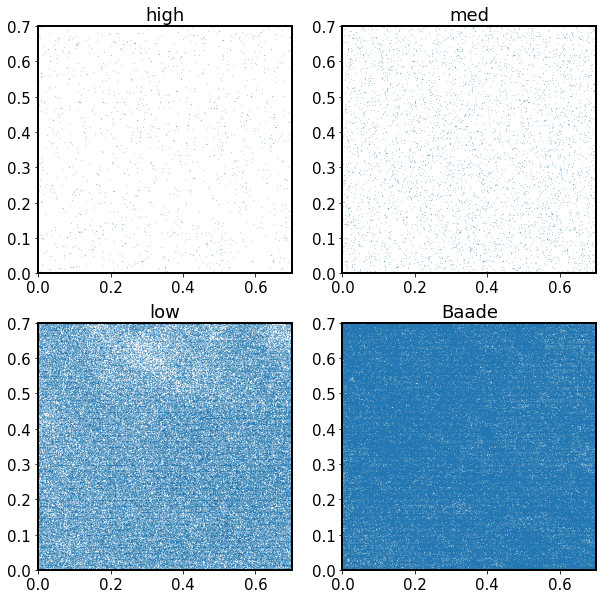

In [46]:
%matplotlib inline
fig,axs  = plt.subplots(2,2,figsize=(10,10))
ax = np.ravel(axs)
i = 0 
for name in stars.keys():
    ra = stars[name]['ra'] - min(stars[name]['ra'])
    dec =  stars[name]['dec'] - min( stars[name]['dec'])
    print(min(ra), max(ra))
    print(min(dec), max(dec))
    ax[i].scatter(ra,dec,s=0.01)#, bins='log')
    ax[i].set_title(name)
    ax[i].set_xlim(0,0.7)
    ax[i].set_ylim(0,0.7)
    i += 1 

In Baade's window we see NGC6522 (left) and NGC6528 (right)  : 

Text(0, 0.5, 'dec')

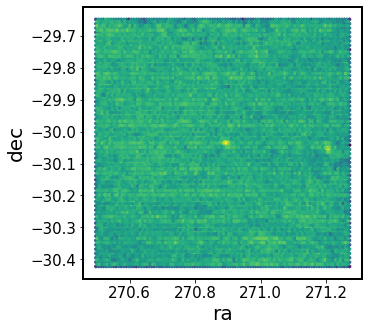

In [47]:
name='Baade'
fig,ax=  plt.subplots(1,1,figsize=(5,5))
ax.hexbin(stars[name]['ra'], stars[name]['dec'], bins='log')

ngc6528  = SkyCoord(ra='18h 04m 49.61s',dec='−30° 03′ 20.8″', 
                    frame='icrs')
ngc6522 = SkyCoord(ra='18h 3m 34.1s', dec='−30° 2′ 2.3″',
                  frame='icrs')
ax.set_xlabel('ra')
ax.set_ylabel('dec')
#ax.scatter(ngc6528.icrs.ra.deg, ngc6528.icrs.dec.deg, marker='D', s=100) # right 

Save these catalogs with and without g>11 cut   as PhoSim catalogs ... (Note that the output of AXS is (0,360) , (-90,90), which is the same format as that of PhoSim).  I use the same exactly the same writing routine as ts_phosim `exportSkyToFile` : https://github.com/lsst-ts/ts_phosim/blob/master/python/lsst/ts/phosim/SkySim.py 
    
    

In [6]:
import os

aosPath = '/epyc/users/suberlak/Commissioning/aos/'
gaiaPath = 'ts_phosim/notebooks/analysis_scripts/results_gaia/'
path = os.path.join(aosPath, gaiaPath)
for name in stars.keys():
    for cutMag in [0,11]:
        mask = stars[name]['phot_g_mean_mag'] > cutMag 
        selection = stars[name][mask]
        selection['starId'] = np.arange(len(selection))
        print('Saving PhoSim star catalog for %s , g>%d : %d/%d stars '%(name, cutMag, 
                                                                         len(selection),len(mask)))

        # Add the header (star ID, ra, decl, magnitude)
        content = "# Id\t Ra\t\t Decl\t\t Mag\n" # initialize the first output line ... 
        for i in range(len(selection['starId'])):
            content += "%d\t %3.6f\t %3.6f\t %3.6f\n" % (
                selection['starId'][i], selection['ra'][i], selection['dec'][i], 
                selection['phot_g_mean_mag'][i])
    
        if cutMag >0 : 
            fname = 'starCatGAIA_'+name+'_gt'+str(cutMag)+'.txt'
        else:
            fname = 'starCatGAIA_'+name+'_full.txt'
        outputFilePath = path+fname

        # Write into file
        fid = open(outputFilePath, "w")
        fid.write(content)
        fid.close()

Saving PhoSim star catalog for high , g>0 : 1759/1759 stars 
Saving PhoSim star catalog for high , g>11 : 1752/1759 stars 
Saving PhoSim star catalog for med , g>0 : 5805/5805 stars 
Saving PhoSim star catalog for med , g>11 : 5789/5805 stars 
Saving PhoSim star catalog for low , g>0 : 222070/222070 stars 
Saving PhoSim star catalog for low , g>11 : 222034/222070 stars 
Saving PhoSim star catalog for Baade , g>0 : 540262/540262 stars 
Saving PhoSim star catalog for Baade , g>11 : 540204/540262 stars 


In [7]:
import os 



In [9]:
cwd = os.getcwd()

In [12]:
os.chdir('/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/')

In [15]:
import subprocess

In [16]:
outputDir = 'results_gaia/dr2_low_full_2020_24_wide/'
inputDirPath = os.path.join(outputDir, 'input')
filesToRemove = ['isr_config.py','registry.sqlite3' ,'_mapper']
for file in  filesToRemove:
    filePath = os.path.join(inputDirPath, file)
    if os.path.exists(filePath):
        print('Removing following file: input/%s'%file)
    cmd = ["rm", filePath]
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE)
    #runProgram("rm", argstring=filePath)

Removing following file: input/_mapper


### Check against LSST reference catalog:

In [1]:
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
import lsst.daf.persistence as dafPersist
import lsst.afw.coord as afwCoord
import lsst.geom
refCatDir = '/astro/users/ajc26/epycuser/LSST-Commissioning/aoc/gaia_refcat'
butler = dafPersist.Butler(refCatDir)
config = LoadIndexedReferenceObjectsTask.ConfigClass()
refObjLoader = LoadIndexedReferenceObjectsTask(butler, config=config)


Make queries similar to the gaia catalog; make sure to have a circle big enough to include the entire square (if square half-width is `a=0.387` deg, then we need a circle with a radius equal to at least $a\sqrt{2}$ to include the entire square):

First, load the file with definitions of Galactic fields:

In [2]:
from astropy.table import Table
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join

gt = Table.read('GAIA_DR2_Galactic_fields.txt', format='ascii')

#read in the full GAIA catalogs
stars = {}
for i in range(len(gt)):
    name = gt['name'][i]
    fname = name+'_gaia_DR2_comcam_wide.txt'
    t = Table.read(fname,format='ascii')
    print('Loading %s'%fname)
    stars[name] = t 
   

In [3]:
gt

name,l_deg,b_deg,ra,dec
str5,float64,float64,float64,float64
high,0.0,85.0,197.46441300863182,24.33554243027582
med,0.0,40.0,233.01733592061046,-4.447088188407341
low,0.0,10.0,257.11044958320826,-23.409732178640596
Baade,1.02,-3.92,270.88380338652223,-30.035274475954893


Now do queries against these locations :

In [4]:
%%time

import numpy as np 

refCats={}

gt = Table.read('GAIA_DR2_Galactic_fields.txt', format='ascii')
a  = 0.387 # half-width of GAIA DR2 queries in degrees 

circleRadiusDeg = 1.2*np.sqrt(2)*a # I add 20% just to be sure 
print('Query circle radius is %.3f degrees'%circleRadiusDeg)

for i in range(len(gt)):
    name = gt['name'][i]
    ra = gt['ra'][i]
    dec = gt['dec'][i]
    print('Querying for ', name, ra, dec,  )
    
    center = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
    radius = lsst.geom.Angle(circleRadiusDeg, lsst.geom.degrees)
    result = refObjLoader.loadSkyCircle(center, radius, filterName='phot_g_mean')
    refCat = result.refCat
    refCats[name] = refCat.asAstropy()

Query circle radius is 0.657 degrees
Querying for  high 197.46441300863182 24.33554243027582
Querying for  med 233.01733592061046 -4.447088188407341
Querying for  low 257.11044958320826 -23.409732178640596
Querying for  Baade 270.88380338652223 -30.035274475954893
CPU times: user 1min 5s, sys: 1.54 s, total: 1min 7s
Wall time: 1min 7s


#### Compare these refcats to Gaia DR2 full catalog...

In [5]:
stars['high'][:5]

ra,dec,phot_g_mean_mag,phot_variable_flag,designation,phot_g_n_obs,dup
float64,float64,float64,str13,str28,int64,int64
197.08359327400353,24.2138864676331,16.461692810058594,NOT_AVAILABLE,Gaia DR2 3945127748587042688,352,0
197.09919710867575,24.203613114551978,19.573123931884766,NOT_AVAILABLE,Gaia DR2 3945127538132594816,341,0
197.11593280310478,24.20085227209597,16.960987091064453,NOT_AVAILABLE,Gaia DR2 3945127576788350976,335,0
197.21173114389248,24.211787160584507,19.89188575744629,NOT_AVAILABLE,Gaia DR2 3945081981414740480,94,0
197.23666944219437,24.201184348623105,20.442291259765625,NOT_AVAILABLE,Gaia DR2 3945081152485796480,273,0


In [54]:
from astropy.table import Table
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join

from astropy.time import Time

from astropy.coordinates import SkyCoord
from astropy import units as u

stars_matched = {}

for name in stars.keys():
    print('Crossmatching %s GAIA DR2 full catalog to refCat query around that location'%name)
    star = stars[name]
    c1_gaia = SkyCoord(ra=star['ra'], dec=star['dec'], unit='deg', frame='icrs')

    ref = refCats[name]
    c2_ref = SkyCoord(ra=ref['coord_ra'], dec=ref['coord_dec'], unit='rad', frame='icrs')
 
    #indices matching c1 to c2 are to c2
    idx, sep2d, sep3d = c1_gaia.match_to_catalog_sky(c2_ref)
    
    ref['coord_ra_deg'] = c2_ref.ra.deg
    ref['coord_dec_deg'] = c2_ref.dec.deg

    star_ref = hstack([star,  ref[idx]])
    star_ref['d2d_asec']  = sep2d.arcsec # in arcsec 
    
    print('%d of %d stars have a match within 1 asec (or less)'%(len(star_ref),
                                                                 np.sum(sep2d.arcsec<1)))
    # store in a dict the 
    # GAIA DR2 catalog 
    # with corresponding entries from 
    # LSST refCat 
    stars_matched[name] = star_ref
    

Crossmatching high GAIA DR2 full catalog to refCat query around that location
1643 of 1643 stars have a match within 1 asec (or less)
Crossmatching med GAIA DR2 full catalog to refCat query around that location
5458 of 5458 stars have a match within 1 asec (or less)
Crossmatching low GAIA DR2 full catalog to refCat query around that location
207883 of 207883 stars have a match within 1 asec (or less)
Crossmatching Baade GAIA DR2 full catalog to refCat query around that location
508343 of 508343 stars have a match within 1 asec (or less)


Save the cross-matched GAIA DR2 - refCat catalogs for later :

In [60]:
for name in stars_matched.keys():
    fname = name+'_gaia_DR2_comcam_wide_refCat.txt'
    stars_matched[name].write(fname, format='ascii',overwrite=True)
    print('Saved as %s'%fname)
print('In %s'%os.getcwd())

Saved as high_gaia_DR2_comcam_wide_refCat.txt
Saved as med_gaia_DR2_comcam_wide_refCat.txt
Saved as low_gaia_DR2_comcam_wide_refCat.txt
Saved as Baade_gaia_DR2_comcam_wide_refCat.txt
In /data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_notebooks


In [51]:
# Units for refCats are now nanoJanskys : 
# https://community.lsst.org/t/photocalib-has-replaced-calib-welcoming-our-nanojansky-overlords/3648 

# import astropy.units as u
# x = star_ref['phot_g_mean_flux'].data
# a = (x*u.nJy).to(u.ABmag)

#star_ref[['ra','dec','phot_g_mean_mag', 'coord_ra_deg', 'coord_dec_deg', 'phot_g_mean_AB_mag']]

In [41]:
# There is about 0.1 mag offset between
# the phot_g_mean and the AB mag derived from
# phot_g_mean_flux... 

# import matplotlib.pyplot as plt 
# g1 = star_ref['phot_g_mean_mag']
# g2 = star_ref['phot_g_mean_AB_mag']
# plt.scatter(g1, g2-g1,s=0.1  )
# plt.xlabel('g')
# plt.ylabel('g-g(AB)')

## Make catalogs for four corner WFS sensors 

at the above locations (for each boresight, find the location of four corner sensors, and do four small queries, then merge together as PhoSim input catalog). If I queried for a full LSST FOV at each boresight (~2.5x2.5 degres) the catalog size would be quite large (~GB for Baade).

Read the location of four WFS sensors if boresight is (0,0):

In [49]:
from astropy.table import Table
wfs = Table.read('GAIA_WFS_center_coords.txt', format='ascii')

Given the locations of four galactic fields, treat the above as the offsets to be added to each location:

In [51]:
gt = Table(data=[['high','med','low','Baade'],
                 [0,0,0,1.02],
                 [85,40,10,-3.92 ]], 
                 names=['name', 'l_deg','b_deg'])

gaia_coords = SkyCoord(l=gt['l_deg'],b=gt['b_deg'], 
                       frame='galactic', unit='deg')
gaia_ra = gaia_coords.icrs.ra.deg
gaia_dec = gaia_coords.icrs.dec.deg

gt['ra_cen'] = gaia_ra
gt['decl_cen'] = gaia_dec

In [52]:

fieldName = []
sensorName = []
raInDeg = []
declInDeg = []

for i in range(len(gt)):
    field = gt['name'][i]
    print('\n%s'%field)
    raCen, declCen = gt['ra_cen'][i], gt['decl_cen'][i]
    
    print(raCen, declCen)
    
    for j in range(len(wfs)):
        dra = wfs['ra'][j]
        ddec = wfs['dec'][j]
        raWfs = raCen + dra
        decWfs = declCen + ddec
        sensor = wfs['sensorName'][j]
        
        print(sensor, raWfs, decWfs)
        
        fieldName.append(field)
        sensorName.append(sensor)
        raInDeg.append(raWfs)
        declInDeg.append(decWfs)
        
wfsGaiaCoords = Table(data=[fieldName, sensorName, raInDeg, declInDeg], 
                      names=['fieldName', 'sensorName', 'raInDeg', 'declInDeg'])


high
197.46441300863182 24.33554243027582
R44_S00_C0 198.64559480519915 25.51412423817349
R00_S22_C0 196.28458713854224 23.15739695628242
R40_S02_C0 198.6411752479128 23.160845781835317
R04_S20_C0 196.2874232670173 25.509831501353446

med
233.01733592061052 -4.447088188407342
R44_S00_C0 234.19851771717785 -3.2685063805096695
R00_S22_C0 231.83751005052093 -5.625233662400741
R40_S02_C0 234.1940981598915 -5.621784836847843
R04_S20_C0 231.840346178996 -3.272799117329715

low
257.11044958320826 -23.40973217864059
R44_S00_C0 258.2916313797756 -22.231150370742917
R00_S22_C0 255.93062371311868 -24.58787765263399
R40_S02_C0 258.2872118224892 -24.58442882708109
R04_S20_C0 255.93345984159373 -22.23544310756296

Baade
270.88380338652223 -30.035274475954893
R44_S00_C0 272.06498518308956 -28.85669266805722
R00_S22_C0 269.70397751643264 -31.213419949948292
R40_S02_C0 272.0605656258032 -31.209971124395395
R04_S20_C0 269.7068136449077 -28.860985404877265


Do the 16 spark queries:

In [53]:
%%time 

a = 0.387# half-width of comcam FOV in deg  - needed to increase from .352,
# because while this was enough in ra, it left a stripe about 10% of the CCD size
# iterate over centers of each square 

#a = a/3.0 # since for WFS each field is basically one ComCam sensor, and ComCam FOV 
# is 3x3 sensors 

# note:  _gaia_DR2_comcam.txt   used a = 0.352, but it turned out insufficient on the edges,
# so I expanded that to a = 0.387, storing as _gaia_DR2_comcam_wide.txt

for i in range(len(wfsGaiaCoords)):
    field = wfsGaiaCoords['fieldName'][i]
    sensor = wfsGaiaCoords['sensorName'][i]
    print(field,sensor)
    ra,dec = wfsGaiaCoords['raInDeg'][i], wfsGaiaCoords['declInDeg'][i]
    ra_min = ra - a ; ra_max = ra + a
    dec_min = dec - a ; dec_max = dec + a 
    print('Querying  %.3f<ra<%.3f   , %.3f<dec<%.3f'%\
          (ra_min,ra_max,dec_min,dec_max))
    res_pd = gaia.region(ra1=ra_min, ra2=ra_max, 
                         dec1=dec_min, dec2=dec_max).select("ra", 
                        "dec","phot_g_mean_mag","phot_variable_flag",
                        "designation",  "phot_g_n_obs","dup").toPandas()
    res = Table.from_pandas(res_pd)
    name = '%s_%s_gaia_DR2_%.3f-deg_wide.txt'%(field,sensor,a)
    print('Saved as %s'%name)
    res.write(name,format='ascii')
    
print('Done')

high R44_S00_C0
Querying  198.259<ra<199.033   , 25.127<dec<25.901
Saved as high_R44_S00_C0_gaia_DR2_0.387000-deg_wide.txt
high R00_S22_C0
Querying  195.898<ra<196.672   , 22.770<dec<23.544
Saved as high_R00_S22_C0_gaia_DR2_0.387000-deg_wide.txt
high R40_S02_C0
Querying  198.254<ra<199.028   , 22.774<dec<23.548
Saved as high_R40_S02_C0_gaia_DR2_0.387000-deg_wide.txt
high R04_S20_C0
Querying  195.900<ra<196.674   , 25.123<dec<25.897
Saved as high_R04_S20_C0_gaia_DR2_0.387000-deg_wide.txt
med R44_S00_C0
Querying  233.812<ra<234.586   , -3.656<dec<-2.882
Saved as med_R44_S00_C0_gaia_DR2_0.387000-deg_wide.txt
med R00_S22_C0
Querying  231.451<ra<232.225   , -6.012<dec<-5.238
Saved as med_R00_S22_C0_gaia_DR2_0.387000-deg_wide.txt
med R40_S02_C0
Querying  233.807<ra<234.581   , -6.009<dec<-5.235
Saved as med_R40_S02_C0_gaia_DR2_0.387000-deg_wide.txt
med R04_S20_C0
Querying  231.453<ra<232.227   , -3.660<dec<-2.886
Saved as med_R04_S20_C0_gaia_DR2_0.387000-deg_wide.txt
low R44_S00_C0
Querying 

Read into a dictionary:

In [54]:
catalogs = {}
for field in ['high','med','low','Baade']:
    catalogs[field]  = {}
    for sensor in np.unique(wfs['sensorName'].data):
        name = '%s_%s_gaia_DR2_%f-deg_wide.txt'%(field,sensor,a)
        catalogs[field][sensor] = Table.read(name, format='ascii')
        print('Read in %s'%name)
        
        
from astropy.table import  vstack

combined  = {}
for field in ['high','med','low','Baade']:
    combined[field] = vstack([catalogs[field]['R00_S22_C0'], 
                          catalogs[field]['R04_S20_C0'],
                          catalogs[field]['R40_S02_C0'],
                          catalogs[field]['R44_S00_C0']
                         ])
catalogType = 'full'
halfWidth = 0.387 
for field in ['high','med','low','Baade']:
    fname = 'starCatGAIA_%s_%s_WFS_%.3f.txt'%(field,catalogType,halfWidth)
    print('Saved as %s'%fname)
    combined[field].write(fname,format='ascii' )
    
    

Read in high_R00_S22_C0_gaia_DR2_0.387000-deg_wide.txt
Read in high_R04_S20_C0_gaia_DR2_0.387000-deg_wide.txt
Read in high_R40_S02_C0_gaia_DR2_0.387000-deg_wide.txt
Read in high_R44_S00_C0_gaia_DR2_0.387000-deg_wide.txt
Read in med_R00_S22_C0_gaia_DR2_0.387000-deg_wide.txt
Read in med_R04_S20_C0_gaia_DR2_0.387000-deg_wide.txt
Read in med_R40_S02_C0_gaia_DR2_0.387000-deg_wide.txt
Read in med_R44_S00_C0_gaia_DR2_0.387000-deg_wide.txt
Read in low_R00_S22_C0_gaia_DR2_0.387000-deg_wide.txt
Read in low_R04_S20_C0_gaia_DR2_0.387000-deg_wide.txt
Read in low_R40_S02_C0_gaia_DR2_0.387000-deg_wide.txt
Read in low_R44_S00_C0_gaia_DR2_0.387000-deg_wide.txt
Read in Baade_R00_S22_C0_gaia_DR2_0.387000-deg_wide.txt
Read in Baade_R04_S20_C0_gaia_DR2_0.387000-deg_wide.txt
Read in Baade_R40_S02_C0_gaia_DR2_0.387000-deg_wide.txt
Read in Baade_R44_S00_C0_gaia_DR2_0.387000-deg_wide.txt
starCatGAIA_high_full_WFS_0.387.txt


starCatGAIA_med_full_WFS_0.387.txt


starCatGAIA_low_full_WFS_0.387.txt


starCatGAIA_Baade_full_WFS_0.387.txt


In [55]:
import os


aosPath = '/epyc/users/suberlak/Commissioning/aos/'
gaiaPath = 'ts_phosim/notebooks/analysis_scripts/results_gaia/'
path = os.path.join(aosPath, gaiaPath)

catalogType = 'full'

for field in ['high','med','low','Baade']:
    selection = combined[field]
    selection['starId'] = np.arange(len(selection))
    print('\nSaving PhoSim WFS full GAIA DR2 star catalog for %s : %d stars '%(field, len(selection)))
    
    # Add the header (star ID, ra, decl, magnitude)
    content = "# Id\t Ra\t\t Decl\t\t Mag\n" # initialize the first output line ... 
    for i in range(len(selection['starId'])):
        content += "%d\t %3.6f\t %3.6f\t %3.6f\n" % (
            selection['starId'][i], selection['ra'][i], selection['dec'][i], 
            selection['phot_g_mean_mag'][i])
    path = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/'
    fname = 'starCatGAIA_'+name+'_full.txt'
    fname = 'starCatGAIA_%s_%s_WFS_%.3f.txt'%(field,catalogType,halfWidth)
    print('Saving as %s'%fname)
    outputFilePath = path+fname

    # Write into file
    fid = open(outputFilePath, "w")
    fid.write(content)
    fid.close()


Saving PhoSim WFS full GAIA DR2 star catalog for high : 6526 stars 
Saving as starCatGAIA_high_full_WFS_0.387.txt

Saving PhoSim WFS full GAIA DR2 star catalog for med : 21919 stars 
Saving as starCatGAIA_med_full_WFS_0.387.txt

Saving PhoSim WFS full GAIA DR2 star catalog for low : 690111 stars 
Saving as starCatGAIA_low_full_WFS_0.387.txt

Saving PhoSim WFS full GAIA DR2 star catalog for Baade : 1965231 stars 
Saving as starCatGAIA_Baade_full_WFS_0.387.txt
